IMPORTING MODULES

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import shutil
from imblearn.over_sampling import SMOTE
from PIL import Image
from io import BytesIO

DATA PREPROCESSING

In [ ]:
#reading the metadata file
metadata = pd.read_csv('/Users/alex/Desktop/projects/SkinCancer/HAM10000_metadata.csv')
metadata.head()

In [3]:
#checking for missing values
metadata.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [4]:
#isolating the columns needed for directory preprocessing
metadata = metadata[['image_id','dx']]
metadata.head()

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [132]:
#building a dictionary with every image_id and dx
df = {}
for image_id, dx in zip(metadata['image_id'], metadata['dx']):
    df[image_id] = dx

#moving every file by code into their specific dx directory
files_in_source = os.listdir('/Users/alex/Desktop/projects/SkinCancer/dataset_pre')

source_pathname = '/Users/alex/Desktop/projects/SkinCancer/dataset_pre'
destination_pathname = '/Users/alex/Desktop/projects/SkinCancer/dataset'

for elem_with_extension in files_in_source:
    elem, extension = os.path.splitext(elem_with_extension)
    if elem in df:
        source_file_path = os.path.join(source_pathname, f'{elem}.jpg')
        destination_folder = os.path.join(destination_pathname, df[elem])
        destination_file_path = os.path.join(destination_folder, f'{elem}.jpg')        
        shutil.copy(source_file_path, destination_file_path)

LOADING THE DATASET

In [2]:
ds = tf.keras.preprocessing.image_dataset_from_directory('/Users/alex/Desktop/projects/SkinCancer/dataset', label_mode='categorical', batch_size=None, image_size=(100, 75))

Found 10015 files belonging to 7 classes.


In [3]:
class_names = ds.class_names
class_names

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

DEALING WITH CLASS IMBALANCE PROBLEM

In [5]:
#creating a list of images and labels for better preprocessing
images = []
labels = []
for image, label in ds:
    images.append(image)
    labels.append(label)

In [6]:
images = np.array(images)
images.shape

(10015, 100, 75, 3)

In [7]:
labels = np.array(labels)
labels.shape

(10015, 7)

In [8]:
#creating the X dataset for SMOTE
flatten = tf.keras.models.Sequential([
    tf.keras.layers.Flatten()
])
X = flatten(images)
X = X.numpy()
X.shape

(10015, 22500)

In [9]:
#creating the y dataset for SMOTE
y = []
for label in labels:
    y.append(np.argmax(label))
y = np.array(y)
y.shape

(10015,)

In [10]:
#class counts before SMOTE
unique_classes, class_counts = np.unique(y, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    print(f'Class {cls}: {count} samples')

Class 0: 327 samples
Class 1: 514 samples
Class 2: 1099 samples
Class 3: 115 samples
Class 4: 1113 samples
Class 5: 6705 samples
Class 6: 142 samples


In [11]:
#using SMOTE for oversampling the minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [13]:
#class counts after SMOTE
unique_classes, class_counts = np.unique(y_resampled, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    print(f'Class {cls}: {count} samples')

Class 0: 6705 samples
Class 1: 6705 samples
Class 2: 6705 samples
Class 3: 6705 samples
Class 4: 6705 samples
Class 5: 6705 samples
Class 6: 6705 samples


In [14]:
X_reshaped = np.reshape(X_resampled, (-1, 100, 75, 3))
X_reshaped.shape

(46935, 100, 75, 3)

In [15]:
y_reshaped = tf.keras.utils.to_categorical(y_resampled)
y_reshaped

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [16]:
#rebuilding tensorflow dataset
new_ds = tf.data.Dataset.from_tensor_slices((X_reshaped, y_reshaped))

SPLITTING THE DATA

In [17]:
#build a function to partition the data into training, validation and test data
def validation_partition(df, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size = 100):
    df_size = len(df)
    if shuffle:
        df = df.shuffle(shuffle_size, seed=42)
    
    train_size = int(df_size*train_split)
    val_size = int(df_size*val_split)
    
    
    train_df = df.take(train_size)
    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size+val_size)
    return train_df, test_df, val_df

train_df, test_df, val_df = validation_partition(new_ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=100)

BUILDING A TENSORFLOW PIPELINE FOR BETTER COMPUTATION

In [18]:
def make_pipe(DATA, RATE):
    return DATA.batch(64).cache().shuffle(RATE).prefetch(tf.data.AUTOTUNE)

train_df = make_pipe(train_df, 100)
test_df = make_pipe(test_df, 100)
val_df = make_pipe(val_df, 100)

In [19]:
len(train_df), len(val_df), len(test_df)

(587, 74, 74)

VARIABLE DECLARATION

In [9]:
#building a sequential layer that preprocess images (resizing, rescaling)
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 75
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
THRESHOLD = 0.5
METRICS = [
    'accuracy',
    tf.keras.metrics.AUC(num_thresholds=100, thresholds=[THRESHOLD]),
    tf.keras.metrics.Precision(thresholds=THRESHOLD),
    tf.keras.metrics.Recall(thresholds=THRESHOLD)
]
METRICS_LIST = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
EPOCHS = 100

MODEL CREATION

In [28]:
#build a function for model creation and customisation
def create_model(LEARNING_RATE, METRICS):
    model = tf.keras.models.Sequential([
        resize_and_rescale,
        tf.keras.layers.Conv2D(32, (3, 3,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, (3, 3,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax'),])
    
    model.build(input_shape=(None, IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics = METRICS)
    return model

my_model = create_model(LEARNING_RATE, METRICS)

In [29]:
my_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 100, 75, 3)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 98, 73, 32)        896       
                                                                 
 batch_normalization_3 (Bat  (None, 98, 73, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 34, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 47, 34, 64)       

MODEL TRAINING

In [30]:
#create callbacks for saving the best weights, for dynamic learning rate and early stopping
checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

In [31]:
#create a function for model training
def train_model(MODEL, TRAIN_DATA, EPOCHS, BATCH_SIZE, VAL_DATA):
    history = MODEL.fit(TRAIN_DATA, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=VAL_DATA, callbacks=[model_checkpoint_callback, reduce_lr_callback, early_stopping_callback])
    return history

history = train_model(MODEL=my_model, TRAIN_DATA=train_df, EPOCHS=EPOCHS, BATCH_SIZE=BATCH_SIZE, VAL_DATA=val_df)

Epoch 1/100
587/587 [==============================] - ETA: 0s - loss: 1.0297 - accuracy: 0.6857 - auc: 0.7843 - precision: 0.7469 - recall: 0.6026
Epoch 1: val_loss improved from inf to 6.87854, saving model to best_model.h5
587/587 [==============================] - 135s 228ms/step - loss: 1.0297 - accuracy: 0.6857 - auc: 0.7843 - precision: 0.7469 - recall: 0.6026 - val_loss: 6.8785 - val_accuracy: 0.5706 - val_auc: 0.7512 - val_precision: 0.6031 - val_recall: 0.5642 - lr: 0.0010
Epoch 2/100
587/587 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.7531 - auc: 0.8295 - precision: 0.8177 - recall: 0.6843
Epoch 2: val_loss improved from 6.87854 to 6.57133, saving model to best_model.h5
587/587 [==============================] - 134s 228ms/step - loss: 0.7393 - accuracy: 0.7531 - auc: 0.8295 - precision: 0.8177 - recall: 0.6843 - val_loss: 6.5713 - val_accuracy: 0.2376 - val_auc: 0.5400 - val_precision: 0.2249 - val_recall: 0.1879 - lr: 0.0010
Epoch 3/100
587/587 

MODEL EVALUATION

In [32]:
#testing the model performance on test set
score = my_model.evaluate(test_df)

2023-12-24 18:44:19.010202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:20: Filling up shuffle buffer (this may take a while): 1 of 100


 2/74 [..............................] - ETA: 3s - loss: 0.0330 - accuracy: 0.9922 - auc: 0.9915 - precision: 0.9921 - recall: 0.9844   

2023-12-24 18:44:20.604113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


74/74 [==============================] - 17s 44ms/step - loss: 0.0636 - accuracy: 0.9774 - auc: 0.9867 - precision: 0.9797 - recall: 0.9768


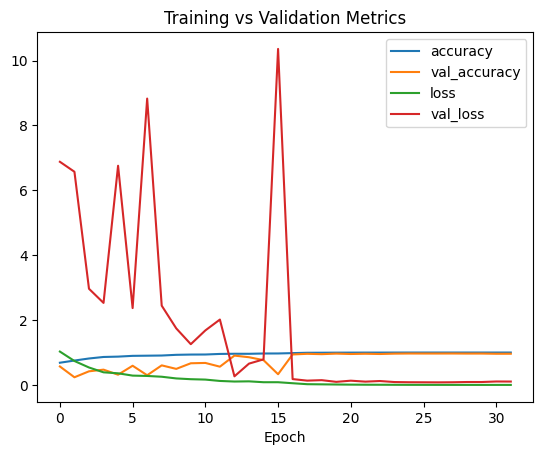

In [33]:
#create a function for checking the model metrics
def plot_metrics(HISTORY, METRICS_LIST):
    for m in METRICS_LIST:
        plt.plot(HISTORY.epoch, HISTORY.history[m], label=m)
    plt.legend()
    plt.xlabel('Epoch')
    plt.title('Training vs Validation Metrics')
    plt.ylim()

plot_metrics(history, METRICS_LIST)

MODEL SAVING

In [34]:
#create a function for saving the model in a specified path
def save_model(FOLDER_PATH, MODEL):
    def find_index(FOLDER_PATH):
        index = 0
        while os.path.exists(os.path.join(FOLDER_PATH,f'model_{index}.keras')):
            index += 1
        return index
    index = find_index(FOLDER_PATH)
    MODEL.save(os.path.join(FOLDER_PATH, f'model_{index}.keras'))

save_model('../models/',my_model)

MODEL TESTING

In [5]:
model_to_test = tf.keras.models.load_model('/Users/alex/Desktop/projects/SkinCancer/models/model_1.keras')
model_to_test.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 100, 75, 3)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 98, 73, 32)        896       
                                                                 
 batch_normalization_3 (Bat  (None, 98, 73, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 34, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 47, 34, 64)       

1/1 [==============================] - 0s 14ms/step


{'class': 'nv', 'confidence': '99.53%'}

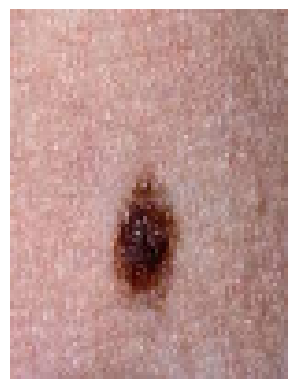

In [35]:
#creating a function that handle prediction
def predict(IMAGE, MODEL, CLASS_NAMES):
    image = tf.image.resize(IMAGE, [IMAGE_WIDTH, IMAGE_HEIGHT])
    img_batch = np.expand_dims(image, 0)
    plt.imshow(img_batch[0].astype('uint8'))
    plt.axis('off')
    predictions = MODEL.predict(img_batch)
    predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    return {
        'class' : predicted_class,
        'confidence' : f'{round(float(confidence*100), 2)}%'
    }

image = np.array(Image.open('/Users/alex/Desktop/projects/SkinCancer/testing_images/Unknown.jpeg'))
predict(image, model_to_test, class_names)